In [1]:
import sys
import os
base_dir = os.path.abspath(".")
sys.path.append(base_dir)

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from utils import *
from models.CtRNet import CtRNet



# DREAM dataset (Panda)

In [2]:
import argparse
from imageloaders.DREAM import ImageDataLoaderReal, load_camera_parameters
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.data_folder = "/media/jingpei/DATA/DREAM/data/real/panda-3cam_azure"
args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.evaluate = True
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/panda/panda-3cam_azure/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Panda/panda.urdf")

args.robot_name = 'Panda' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.scale = 0.5
args.height = 480
args.width = 640
args.fx, args.fy, args.px, args.py = load_camera_parameters(args.data_folder)

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [10]:
CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/weights/panda/panda-3cam_azure/net.pth


In [11]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageDataLoaderReal(data_folder = args.data_folder, scale = args.scale, trans_to_tensor = trans_to_tensor)

In [13]:
img, joint_angles = dataset.__getitem__(666) 

if args.use_gpu:
    img = img.cuda()

cTr, points_2d, segmentation = CtRNet.inference_single_image(img[None], joint_angles.cpu().squeeze())
print(CtRNet.cTr_to_pose_matrix(cTr))


tensor([[ 0.8512,  0.5259, -0.0062, -0.1945],
        [ 0.0963, -0.1670, -0.9815,  0.3966],
        [-0.5170,  0.8343, -0.1926,  1.0456],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0',
       grad_fn=<CopySlices>)


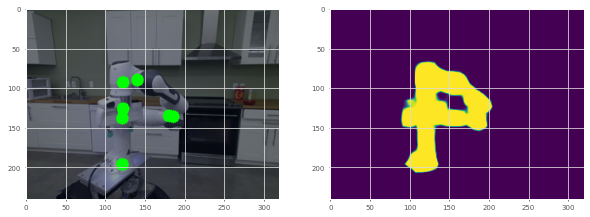

In [14]:
img_np = to_numpy_img(img)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.subplot(1,2,2)
plt.imshow(segmentation[0].squeeze().detach().cpu().numpy())
#plt.imsave("kp.png",img_np)

# Baxter dataset

In [2]:
from imageloaders.baxter import ImageDataLoaderReal

import argparse
parser = argparse.ArgumentParser()

args = parser.parse_args("")

args.data_folder = '/home/jingpei/Desktop/robot_pose_estimation/data_generation/baxter_data'
args.base_dir = "/home/jingpei/Desktop/CtRNet-robot-pose-estimation"
args.use_gpu = True
args.evaluate = True
args.keypoint_seg_model_path = os.path.join(args.base_dir,"weights/baxter/net.pth")
args.urdf_file = os.path.join(args.base_dir,"urdfs/Baxter/baxter_description/urdf/baxter.urdf")

args.robot_name = 'Baxter_left_arm' # "Panda" or "Baxter_left_arm"
args.n_kp = 7
args.scale = 0.3125
args.height = 1536
args.width = 2048
args.fx, args.fy, args.px, args.py = 960.41357421875, 960.22314453125, 1021.7171020507812, 776.2381591796875

# scale the camera parameters
args.width = int(args.width * args.scale)
args.height = int(args.height * args.scale)
args.fx = args.fx * args.scale
args.fy = args.fy * args.scale
args.px = args.px * args.scale
args.py = args.py * args.scale

In [3]:
CtRNet = CtRNet(args)

Loading keypoint segmentation model from /home/jingpei/Desktop/CtRNet-robot-pose-estimation/weights/baxter/net.pth


In [4]:
trans_to_tensor = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = ImageDataLoaderReal(data_folder = args.data_folder, scale = args.scale, trans_to_tensor = trans_to_tensor)

In [5]:
img, joint_angles = dataset.__getitem__(66) 

if args.use_gpu:
    img = img.cuda()

cTr, points_2d, segmentation = CtRNet.inference_single_image(img[None], joint_angles.cpu().squeeze())
print(CtRNet.cTr_to_pose_matrix(cTr))

tensor([[ 0.9164,  0.4009, -0.0032, -0.5970],
        [-0.0475,  0.1008, -0.9939,  0.1607],
        [-0.3981,  0.9107,  0.1114,  1.1810],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0',
       grad_fn=<CopySlices>)


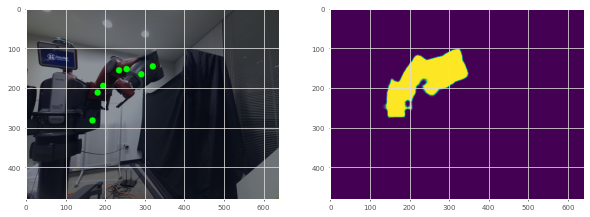

In [6]:
img_np = to_numpy_img(img)
img_np = 0.0* np.ones(img_np.shape) + img_np * 0.6
img_np = overwrite_image(img_np,points_2d.detach().cpu().numpy().squeeze().astype(int), color=(0,1,0))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_np)
plt.subplot(1,2,2)
plt.imshow(segmentation[0].squeeze().detach().cpu().numpy())
#plt.imsave("kp.png",img_np)